<a href="https://www.kaggle.com/code/deepakvk18/credit-default-risk?scriptVersionId=117513390" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Problem Statement and Business Understanding
<div style="font-family: Arial; list-style-type: none; background-color: #52BC77; padding: 10px; border-radius: 10px; color: white;">
<p>💡
    A bank is facing an increasing number of defaults on loans, and needs to improve its credit risk modeling in order to better predict which customers are likely to default on their loans in the future.</p>
<p>    
📑
    The bank needs to identify customers who are at high risk of defaulting on their loans in order to take appropriate action, such as increasing the interest rate on the loan or declining the loan application. This will help the bank reduce its overall risk and increase its profitability. 
    </p>
<p>📈
    By accurately identifying high-risk customers, the bank can also improve its customer relationships by being more transparent about the terms of the loan. Additionally, the bank can use the results of the credit risk modeling to inform its marketing and sales strategies, targeting higher-risk customers with more appropriate products and services.
    </p>
    <p>
🎯
The goal is to accurately identify high-risk loans in order to take appropriate action, such as increasing the interest rate on the loan or declining the loan application, which will help the bank reduce its overall risk and increase its profitability.
    </p></div>

In [ ]:
!jupyter nbextension enable --py --sys-prefix widgetsnbextension

In [ ]:
!pip freeze > requirements.txt

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from category_encoders import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, roc_auc_score, plot_roc_curve, confusion_matrix
from ipywidgets import interact, FloatSlider
from ipywidgets import Play, jslink, HBox, interactive_output
from IPython.display import display
import warnings
import pickle

In [ ]:
warnings.filterwarnings('ignore')
plt.style.use('fivethirtyeight')
sns.set_style('dark')

In [ ]:
df = pd.read_csv('/kaggle/input/loan-data-2015/loan_data_2015.csv')
df.head()

# EDA and Feature Engineering

In [ ]:
df.info()

In [ ]:
def missing_pct(df):
    selected_features = []
    for col in df.columns:
        missing = np.ceil(df[col].isna().sum() / len(df) * 100)
        print(f"Total Missing Values of {col} feature is: {missing}")
        if missing < 50:
            selected_features.append(col)
            
    return selected_features

In [ ]:
feats = missing_pct(df)

In [ ]:
len(feats)

In [ ]:
df = df[feats]

## Identifying Target Column

In [ ]:
df['loan_status'].value_counts()

<div style="font-family: Arial; list-style-type: none; background-color: #E27E39; padding: 10px; border-radius: 10px; color: white;">
    I will be including the following loan statuses from our analysis, as non-risky:
<ul><li>🐬
<b> Fully Paid </b> : refers to the people who have already paid off the loan and are non-risky.</li></ul>
    I will consider the following loan statuses as risky:
<ul><li>🐬
<b> Charged off</b> : means the borrower has been deemed incapable of paying the loan and it will be marked under NPA(Non Performing Asset).</li>
    <li>🐬<b> Default</b> : means the borrower has not paid his/her loan even after 120 days.</li>
    <li>🐬
<b>Late (31-120 days) </b> : means that the borrower has not paid the amount on time and there is a delay in payment of more than 31 days, this label comes under risky loan.</li></ul>
I will also be excluding the following loan statuses from our analysis, as they can go both ways:
<ul>
    <li>
<b> 
    🐬 Current</b> : refers to the current loan cycle, but there is a probability that they might default in future.</li><li>
<b> 🐬 In Grace Period </b> : means the borrower has delayed his payment by 1-15 days, this comes under non-risky loan, but if the borrower does not pay, it becomes risky. Since we cannot say whether the borrower will default or not as of yet, this category  won't be used for the analysis.</li><li>
<b> 🐬 Late(16-30 days)</b> : means that the borrower has delayed his payments by 16-30 days, this can also go both ways, so we are not going to use this label in our analysis.</li>
    <li>🐬
<b> Issued </b> : refers to the loan has been issued just and the payment cycle has not begun, but there is a probability that the borrower may default in future.</li></ul>  
    </div>

In [ ]:
mask = (df['loan_status'] != 'Current') & (df['loan_status'] != 'Issued') & (df['loan_status'] != 'Late (16-30 days)') & (df['loan_status'] != 'In Grace Period')
df = df[mask]
df['risk'] = np.where((df['loan_status'] == 'Charged Off') | (df['loan_status'] == 'Late (31-120 days)') | (df['loan_status'] == 'Default'), 1, 0)

In [ ]:
df.drop('loan_status', axis=1, inplace=True)

In [ ]:
df.shape

## Cleaning Categorical Columns

In [ ]:
cat_cols = df.select_dtypes('object').columns
for col in cat_cols:
    print(col, df[col].nunique())

In [ ]:
df.emp_title.value_counts()

In [ ]:
df.emp_length.value_counts()

In [ ]:
df.home_ownership.value_counts()

In [ ]:
df.verification_status.value_counts()

In [ ]:
df.purpose.value_counts()

In [ ]:
df.title.value_counts()

In [ ]:
df.initial_list_status.value_counts()

In [ ]:
df.application_type.value_counts()

<ul style="font-family: Arial; list-style-type: none; background-color: #BCB152; padding: 10px; border-radius: 3px; color: white;">
  <li>🐬 The Sub Grade column has 35 categorical values which may not be useful, as they would increase the complexity of the dataset and machine learning model. </li>
  <li>🐬 The Employee title column has many categories, it's not useful and should be dropped. </li>
  <li>🐬 The Emp Length column needs to be reformatted as it contains string values instead of numerical values. </li>
  <li>🐬 The Issue_d column is not relevant to the problem and should be dropped. </li>
  <li>🐬 The Payment plan and url columns are not useful, they should be dropped. </li>
  <li>🐬 The Title and Purpose columns are similar and one of them should be dropped. </li>
  <li>🐬 The Zip Code, Address state, and earliest_cr_line columns have high cardinality and should be dropped. </li>
  <li>🐬 The Last payment date, next payment date, and last credit pull date columns have no relation to the default prediction and should be dropped. </li>
  <li>🐬 The Application type column can be dropped as it has no useful information. </li>
</ul>


In [ ]:
df['emp_len'] = df.emp_length.str.findall('([0-9]+)')
df['emp_len'] = df.emp_len.apply(lambda x: float(x[0]) if x is not np.nan else np.nan)

In [ ]:
df['emp_len'].value_counts()

## Numerical Columns

In [ ]:
df.describe().T

In [ ]:
num_cols = df.select_dtypes('number').columns
plt.figure(figsize=(20, 50))
for i in range(len(num_cols)):
    plt.subplot(12, 3, i + 1)
    sns.histplot(data=df, x=num_cols[i])
    plt.title(f'Dist of {num_cols[i]}')

plt.suptitle('Distribution of numerical columns')
plt.tight_layout();

In [ ]:
num_cols = df.select_dtypes('number').columns
plt.figure(figsize=(20, 50))
for i in range(len(num_cols)):
    plt.subplot(12, 3, i + 1)
    sns.boxplot(data=df, x=num_cols[i])
    plt.title(f'Box Plot of {num_cols[i]}')

plt.suptitle('Distribution of numerical columns')
plt.tight_layout();

<ul style="font-family: Arial; list-style-type: none; background-color: #BC528C; padding: 10px; border-radius: 10px; color: white;">
  <li>🐋 The columns delinq_2yrs, inq_last_6mths, pub_rec, out_prncp, out_prncp_inv, total_rec_late_fee, recoveries, collection_recovery_fee, policy_code, collections_12_mths_ex_med, acc_now_delinq, and tot_coll_amt have mostly zeroes which could make it difficult to predict the default. </li>
  <li>🐋 Some outliers from the columns open_acc, revol_balance, total_acc, total_rec_int, tot_cur_balance, and total_rev_hi_lim could be removed. </li>
</ul>

In [ ]:
def clip(series):
    first, second, third, high = series.quantile([0.25, 0.5, 0.75, 0.99])
    return np.where(series > high, high, series)

clip(df['total_rev_hi_lim'])

### Dealing with Multicollinearity

In [ ]:
plt.figure(figsize=(40, 40))
sns.heatmap(df.corr().round(2), annot=True, cmap="Blues");

In [ ]:
corr = df.corr()
upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(np.bool))
drop = [column for column in upper.columns if any(np.abs(upper[column]) > 0.90)]
drop

# Putting it all together

In [ ]:
def missing_pct(df):
    selected_features = []
    for col in df.columns:
        missing = np.ceil(df[col].isna().sum() / len(df) * 100)
#         print(f"Total Missing Values of {col} feature is: {missing}")
        if missing < 50:
            selected_features.append(col)
            
    return selected_features

def clip(series):
    first, second, third, high = series.quantile([0.25, 0.5, 0.75, 0.99])
    return np.where(series > high, high, series)

def wrangle(filepath):
    
    # Read the csv file into dataframe
    df = pd.read_csv(filepath)
    
    # Find the target column and convert it to use for classification
    mask = ((df['loan_status'] != 'Current') & (df['loan_status'] != 'Issued') & 
            (df['loan_status'] != 'Late (16-30 days)') & (df['loan_status'] != 'In Grace Period'))
    df = df[mask]
    df['risk'] = np.where((df['loan_status'] == 'Charged Off') | (df['loan_status'] == 'Late (31-120 days)') | (df['loan_status'] == 'Default'), 1, 0)
    
    # Find the columns to drop
    drop_col = []
    drop_col.extend(['loan_status', 'id', 'member_id'])
    
    # Drop High and Low Cardinal Categorical Features and unimportant categorical columns
    drop_col.extend(['sub_grade', 'issue_d', 'pymnt_plan', 'url', 'purpose', 'zip_code', 'addr_state', 'emp_title',
                     'earliest_cr_line', 'last_pymnt_d', 'next_pymnt_d', 'last_credit_pull_d', 'application_type'])
    
    # Feature Engineering Categorical Columns
    df['emp_len'] = df.emp_length.str.findall('([0-9]+)')
    df['emp_len'] = df.emp_len.apply(lambda x: float(x[0]) if x is not np.nan else np.nan)
    drop_col.append('emp_length')
    df['term'] = df['term'].str[:3].astype(int)
    rules = (df['title'] == 'Debt consolidation') | (df['title'] == 'Credit card refinancing') | (df['title'] == 'Home improvement')
    df['title'] = np.where(rules, df['title'], 'Other')
    
    # Clipping outliers
    clip_cols = ['open_acc', 'revol_bal', 'total_acc', 'total_rec_int', 'tot_cur_bal', 'total_rev_hi_lim']
    for col in clip_cols:
        df[col] = clip(df[col])
    
    # Dropping numerical columns with very skewed distribution
    drop_col.extend(['delinq_2yrs', 'inq_last_6mths', 'pub_rec', 'out_prncp', 'out_prncp_inv', 'total_rec_late_fee', 'recoveries', 
                     'collection_recovery_fee', 'policy_code', 'collections_12_mths_ex_med', 'acc_now_delinq', 'tot_coll_amt'])

    # Dropping columns with multicollinearity
    corr = df.drop('risk', axis=1).corr()
    upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(np.bool))
    drop = [column for column in upper.columns if any(np.abs(upper[column]) > 0.75)]
    drop_col.extend(drop)
    
    # Drop the columns that are not required
    df.drop(columns=drop_col, axis=1, inplace=True)

    # Find percent of missing values in each column and drop columns which has majority of missing values
    feats = missing_pct(df)
    feats
    df = df[feats]
    
    return df

In [ ]:
df = wrangle('/kaggle/input/loan-data-2015/loan_data_2015.csv')
df.shape

In [ ]:
df.isna().sum()

# Data Visualization

### Average Default Rate

In [ ]:
avg_default_rate = df['risk'].mean()
avg_default_rate

In [ ]:
cat_cols = df.select_dtypes('object').columns
plt.figure(figsize=(16, 12))

for i in range(len(cat_cols)):
    plt.subplot(2, 3, i + 1)
    group = df[[cat_cols[i], 'risk']].groupby(by=cat_cols[i]).mean().sort_index()
    sns.barplot(data=group, x=group.index, y='risk')
    plt.xlabel(cat_cols[i])
    plt.ylabel('Avg Risky Loans')
    plt.title(f'Avg Risky Loans by {cat_cols[i]}')
    plt.axhline(y=avg_default_rate, label='Avg Default Rate', color='green', linestyle='--', linewidth=0.7)
    plt.xticks(rotation=60)
    plt.legend()
    
plt.suptitle('Analysis of categorical column with target column')
plt.tight_layout();

<div style="font-family: Arial; list-style-type: none; background-color: #BC5284; padding: 10px; border-radius: 10px; color: white;">
    <ul>
        <li>Loan Grades D, E and F are more vulnerable to being risky than other loans.</li>
        <li>Borrowers with Rented house are more likely to be risky than those with own/morgage home.</li>
        <li>Borrowers with initial list status w are less likely to be risky on an average.</li>
    </ul>
    </div>

# Logistic Regression

## Baseline

In [ ]:
baseline = df['risk'].value_counts(normalize=True).max().round(2)
baseline

In [ ]:
X = df.drop('risk', axis=1)
y = df['risk']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [ ]:
model = make_pipeline(
    OneHotEncoder(use_cat_names=True),
    SimpleImputer(strategy='median'),
    MinMaxScaler(),
    LogisticRegression(class_weight='balanced')
)
model.fit(X_train, y_train)

In [ ]:
print(classification_report(y_test, model.predict(X_test)))

In [ ]:
ConfusionMatrixDisplay.from_estimator(model, X_test, y_test);

In [ ]:
score = roc_auc_score(y_train, model.predict(X_train)).round(2)
score

In [ ]:
plot_roc_curve(model, X_test, y_test, color='purple', linewidth=1.2, label=f'Logistic Regression score={score}')
plt.title('ROC AUC Curve for Credit Risk Model Logistic Regression')
plt.xlabel('False Positive Rate [FPR]')
plt.ylabel('True Positive Rate [TPR]');

# Model Explainability

In [ ]:
odds = model.named_steps['logisticregression'].coef_.flatten()
feats = model.named_steps['onehotencoder'].get_feature_names_out()
importances = pd.Series(odds, index=feats).sort_values()
plt.figure(figsize=(15, 10))
importances.plot(kind='barh')
plt.xlabel('Coeffecients')
plt.ylabel('Features')
plt.axvline(x=0, color='black', linewidth=0.7)
plt.title('Coeffecients of each features in Credit Risk Classification');

<div style="font-family: Arial; list-style-type: none; background-color: #5285BC; padding: 10px; border-radius: 10px; color: white;">
    From the graph above, it can be clearly seen that the following variables positively impact the risk of default (in order):
    <Ol>
        <li> Loan Amount </li>
        <li> Total Rec Int </li>
        <li> Interest Rate </li>
        <li> DTI </li>
        <li> Revol Util </li>
        <li> Open Acc </li>
        <li> Revol Bal </li>
    </Ol>
     It can also be seen that the following variables negatively impact the risk of default (in order):
    <Ol>
        <li> Total Payment </li>
        <li> Total curr Bal</li>
        <li> Total Acc</li>
    </Ol>
</div>

# Deciding the Decision boundary

### Things to consider when changing the decision boundary of the classification model:
<div style="font-family: Arial; list-style-type: none; background-color: #A252BC; padding: 10px; border-radius: 10px; color: white;">
We should consider changing the boundary value of the model if the model is showing high rates of false positives or false negatives. For example, if the model is classifying many non-defaulting loans as defaults (false positives), this may be causing a high number of denied loans for otherwise creditworthy applicants. This can cause frustration and loss of business for the lender. In this case, the lender might want to change the decision boundary to be more lenient, resulting in fewer false positives and more loans being approved.

On the other hand, if the model is classifying many defaulting loans as non-defaulting loans (false negatives), this may be causing a high level of loan defaults and financial loss for the lender. In this case, the lender might want to change the decision boundary to be more strict, resulting in fewer false negatives and more defaults being identified.

It's important to note that changing the decision boundary will likely impact the overall performance of the model, so it should be done with care and after careful evaluation of the trade-offs between the different evaluation metrics. It's also important to consider the business and regulatory context in which the model will be used. And also, it's important to consider the fairness and ethical concerns when adjusting the decision boundary.
    </div>

In [ ]:
@interact(decision_boundary = FloatSlider(value=0.3, min=0.3, max=0.7, step=0.02))
def widget(decision_boundary):
    
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    
    y_preds = np.array(((y_pred_proba) > decision_boundary).astype(int)).reshape(-1, 1)
    fig = plt.figure(figsize=(10,5))
    ax1 = fig.add_subplot(1,2,1)
    disp = ConfusionMatrixDisplay.from_predictions(y_test, y_preds, ax=ax1);
    
    ax2 = fig.add_subplot(1,2,2)
    ax2.axis('off')
    
    # Assumption
    loss_if_default = 100000
    profit_if_not_default = 15000
    
    tn, fp, fn, tp = confusion_matrix(y_test, y_preds).flatten()
    # Amount saved by finding the correct risky loans
    saved = tp * loss_if_default
    # Opportunity cost for false positive and lost amount for false negatives
    lost = fp * profit_if_not_default + fn * loss_if_default
    net = saved - lost

    ax2.text(0,0.65,f'Loss: ${lost}', fontsize=24)
    ax2.text(0,0.5,f'Saved: ${saved}', fontsize=24)
    ax2.text(0,0.35, f'Net: ${net}', fontsize=24)

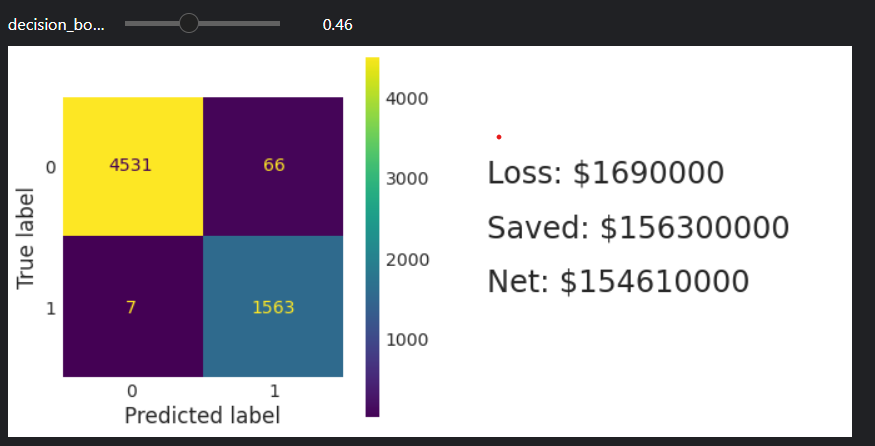

<div style="font-family: Arial; list-style-type: none; background-color: #52B7BC; padding: 10px; border-radius: 10px; color: white;">
    <p>For this problem context, I have assumed that the profit to the bank is <em> 15000 </em>if the borrower does not default and the loss to the bank if the borrower defaults to be <em> 100000 </em>. To make it simpler, I am going to select the decision boundary which brings most positive cash flow to the bank such that they can save the highest amount and earn the highest amount possible from this model. </p>
<p>
    Given the context, it can be seen from the above graph, the decision boundary of <b style="color:yellow;">0.46 </b> gives the most profit to the organization and seems to be the optimum decision boundary.</p>
    </div>

# Model Inference

In [ ]:
with open('credit-risk.pkl', 'wb') as f:
    pickle.dump(model, file=f)

In [ ]:
def predict(loan_amnt, term, int_rate, grade, home_ownership, annual_inc, verification_status, title, dti, 
           open_acc, revol_bal, revol_util, total_acc, initial_list_status, total_pymnt, total_rec_int, tot_cur_bal):
    
    df_dict = {
        'loan_amnt': loan_amnt,
        'term': term,
        'int_rate': int_rate,
        'grade': grade,
        'home_ownership': home_ownership,
        'annual_inc': annual_inc,
        'verification_status': verification_status,
        'title': title,
        'dti': dti,
        'open_acc': open_acc,
        'revol_bal': revol_bal,
        'revol_util': revol_util,
        'total_acc': total_acc,
        'initial_list_status': initial_list_status,
        'total_pymnt': total_pymnt,
        'total_rec_int': total_rec_int,
        'tot_cur_bal': tot_cur_bal
    }
    
    with open('credit-risk.pkl', 'rb') as f:
        mod = pickle.load(f)
        
    inp = pd.DataFrame(df_dict, index=[0])
    
    proba = round(mod.predict_proba(inp)[0][1] * 100, 2)
    
    return f'Probability of risk is {proba}'

In [ ]:
predict(
    9000,
    36,
    12.69,
    'C',
    'RENT',
    65000,
    'Verified',
    'Other',
    2.62,
    5.0,
    2932.0,
    47.3,
    9.0,
    'f',
    9525.1,
    525.11,
    2932.0
)

# Conclusion
<div  style="font-family: Arial; list-style-type: none; background-color: #00214B; padding: 10px; border-radius: 10px; color: white;">
The credit risk modeling aimed to improve the bank's ability to predict which customers are likely to default on their loans in the future. By analyzing the loan-default and identifying which loans are likely to default in the future, the bank can take appropriate action to reduce its overall risk and increase its profitability. By utilizing statistical techniques and machine learning algorithms, we were able to analyze vast amounts of loan data and identify patterns and trends that indicate a higher likelihood of default.
 </div>